In [ ]:
#!pip install --upgrade nvidia-pyindex
##### Make sure that your colab use "T4 GPU"
##### Check it on menu:: runtime > runtime type change
!nvidia-smi

Thu Oct 19 09:52:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import warnings ; warnings.filterwarnings('ignore')
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']=''
os.environ['OMP_NUM_THREADS'] = '1'

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp
import threading

import numpy as np
from IPython.display import display
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from itertools import cycle, count
from textwrap import wrap

import matplotlib
import subprocess
import os.path
import tempfile
import random
import base64
import pprint
import glob
import time
import json
import sys
import gym
import io
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import gc

from gym import wrappers
from subprocess import check_output
from IPython.display import HTML

LEAVE_PRINT_EVERY_N_SECS = 30
ERASE_LINE = '\x1b[2K'
EPS = 1e-6

%matplotlib inline

In [ ]:
torch.cuda.is_available()

False

# Monte-Carlo REINFORCE
### Policy Gradient model

In [ ]:
class PGmodel(nn.Module):
    def __init__(self,
                 input_dim,
                 output_dim,
                 hidden_dims=(32,32),
                 activation_fc=F.relu):
        super(PGmodel, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    def _format(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
            x = x.unsqueeze(0)
        return x

    def forward(self, state):
        x = self._format(state)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        return self.output_layer(x)

    def full_pass(self, state):
        logits = self.forward(state)
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()
        logpa = dist.log_prob(action).unsqueeze(-1)
        entropy = dist.entropy().unsqueeze(-1)
        is_exploratory = action != np.argmax(logits.detach().numpy())
        return action.item(), is_exploratory.item(), logpa, entropy

    def select_action(self, state):
        logits = self.forward(state)
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()
        return action.item()

    def select_greedy_action(self, state):
        logits = self.forward(state)
        return np.argmax(logits.detach().numpy())

### REINFORCE Learning Functions

In [ ]:
def PG_interaction_step(agent, state, env, logpas, rewards,
                     episode_reward, episode_timestep, episode_exploration):
    action, is_exploratory, logpa, _ = agent.full_pass(state)
    new_state, reward, is_terminal, _ = env.step(action)

    logpas.append(logpa)
    rewards.append(reward)

    episode_reward[-1] += reward
    episode_timestep[-1] += 1
    episode_exploration[-1] += int(is_exploratory)

    return new_state, is_terminal

def optimizing_PGmodel(rewards, gamma, logpas, policy_optimizer):
    T = len(rewards)
    discounts = np.logspace(0, T, num=T, base=gamma, endpoint=False)
    returns = np.array([np.sum(discounts[:T-t] * rewards[t:]) for t in range(T)])

    discounts = torch.FloatTensor(discounts).unsqueeze(1)
    returns = torch.FloatTensor(returns).unsqueeze(1)
    logpas = torch.cat(logpas)

    policy_loss = -(discounts * returns * logpas).mean()
    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()
    return

def evaluating(eval_policy_model, eval_env, n_episodes=1, greedy=True):
    rs = []
    for _ in range(n_episodes):
        s, d = eval_env.reset(), False
        rs.append(0)
        for _ in count():
            if greedy:
                a = eval_policy_model.select_greedy_action(s)
            else:
                a = eval_policy_model.select_action(s)
            s, r, d, _ = eval_env.step(a)
            rs[-1] += r
            if d: break
    return np.mean(rs), np.std(rs)


def stats(agent, env, training_time, last_debug_time, results,
          episode_start, episode_seconds, episode_timestep, episode_reward, episode_exploration):
    # stats
    episode_elapsed = time.time() - episode_start
    episode_seconds.append(episode_elapsed)
    training_time += episode_elapsed
    #evaluation_score, _ = self.evaluate(self.policy_model, env)
    evaluation_score, _ = evaluating(agent, env)

    total_step = int(np.sum(episode_timestep))
    evaluation_scores.append(evaluation_score)

    mean_10_reward = np.mean(episode_reward[-10:])
    std_10_reward = np.std(episode_reward[-10:])
    mean_100_reward = np.mean(episode_reward[-100:])
    std_100_reward = np.std(episode_reward[-100:])
    mean_100_eval_score = np.mean(evaluation_scores[-100:])
    std_100_eval_score = np.std(evaluation_scores[-100:])
    lst_100_exp_rat = np.array(
        episode_exploration[-100:])/np.array(episode_timestep[-100:])
    mean_100_exp_rat = np.mean(lst_100_exp_rat)
    std_100_exp_rat = np.std(lst_100_exp_rat)

    wallclock_elapsed = time.time() - training_start
    results[episode-1] = total_step, mean_100_reward, \
        mean_100_eval_score, training_time, wallclock_elapsed

    reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
    reached_max_minutes = wallclock_elapsed >= max_minutes * 60
    reached_max_episodes = episode >= max_episodes
    reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
    training_is_over = reached_max_minutes or \
                       reached_max_episodes or \
                       reached_goal_mean_reward

    elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time() - training_start))
    debug_message = 'el {}, ep {:04}, ts {:06}, '
    debug_message += 'ar 10 {:05.1f}\u00B1{:05.1f}, '
    debug_message += '100 {:05.1f}\u00B1{:05.1f}, '
    debug_message += 'ex 100 {:02.1f}\u00B1{:02.1f}, '
    debug_message += 'ev {:05.1f}\u00B1{:05.1f}'
    debug_message = debug_message.format(
        elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward,
        mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
        mean_100_eval_score, std_100_eval_score)
    print(debug_message, end='\r', flush=True)
    if reached_debug_time or training_is_over:
        print(ERASE_LINE + debug_message, flush=True)
    if training_is_over:
        if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
            #debug_message += '--> reached_max_minutes \u2715'
        if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
            #debug_message += '--> reached_max_episodes \u2715'
        if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
            #debug_message += '--> reached_goal_mean_reward \u2713'
    return training_is_over, reached_debug_time

### REINFORCE Simulation

In [ ]:
environment_settings = {
    'env_name': 'CartPole-v1',
    'gamma': 1.00,
    'max_minutes': 10,
    'max_episodes': 10000,
    'goal_mean_100_reward': 475
}
env_name, gamma, max_minutes, \
max_episodes, goal_mean_100_reward = environment_settings.values()

seed = 12
policy_optimizer_lr = 0.0005

env = gym.make('CartPole-v1')
nS, nA = env.observation_space.shape[0], env.action_space.n


training_start, last_debug_time = time.time(), float('-inf')
torch.manual_seed(seed) ; np.random.seed(seed) ; random.seed(seed)

episode_timestep = []
episode_reward = []
episode_seconds = []
episode_exploration = []
evaluation_scores = []

agent = PGmodel(nS,nA, hidden_dims=(128,64)) # policy_model
policy_optimizer = optim.Adam(agent.parameters(), lr=policy_optimizer_lr) # policy_optimizer

results = np.empty((max_episodes, 5))
# results = [total_step, mean_100_reward, mean_100_eval_score, training_time, wallclock_elapsed]
results[:] = np.nan
training_time = 0

for episode in range(1, max_episodes + 1):
    episode_start = time.time()

    state, is_terminal = env.reset(), False
    episode_reward.append(0.0)
    episode_timestep.append(0.0)
    episode_exploration.append(0.0)

    # collect rollout
    logpas, rewards = [], []
    for step in count():
        state, is_terminal = PG_interaction_step(agent, state, env,
                                              logpas, rewards, episode_reward,
                                              episode_timestep, episode_exploration)
        if is_terminal:
            gc.collect()
            break

    # optimizing the model, once per episode
    optimizing_PGmodel(rewards, gamma, logpas, policy_optimizer)

    # collect statistics
    training_is_over, reached_debug_time = stats(agent, env, training_time, last_debug_time, results,
                                                            episode_start, episode_seconds, episode_timestep,
                                                            episode_reward, episode_exploration)

    if reached_debug_time or training_is_over:
        last_debug_time = time.time()
    if training_is_over: break


el 00:00:00, ep 0000, ts 000016, ar 10 016.0±000.0, 100 016.0±000.0, ex 100 0.5±0.0, ev 017.0±000.0
el 00:00:30, ep 0215, ts 008716, ar 10 061.8±030.2, 100 052.7±033.5, ex 100 0.4±0.1, ev 087.9±074.5
el 00:01:00, ep 0358, ts 019486, ar 10 117.7±071.6, 100 076.5±058.4, ex 100 0.3±0.1, ev 181.3±180.9
el 00:01:30, ep 0476, ts 035158, ar 10 198.8±061.0, 100 142.7±082.7, ex 100 0.3±0.0, ev 256.1±158.1
el 00:02:01, ep 0539, ts 051926, ar 10 271.8±084.7, 100 221.0±103.6, ex 100 0.3±0.0, ev 367.1±138.4
el 00:02:31, ep 0609, ts 066999, ar 10 204.2±035.4, 100 227.1±080.0, ex 100 0.3±0.0, ev 409.5±097.9
el 00:03:01, ep 0680, ts 084661, ar 10 267.6±122.8, 100 246.1±100.0, ex 100 0.3±0.0, ev 449.7±093.8
el 00:03:31, ep 0771, ts 103077, ar 10 184.1±042.6, 100 206.8±124.9, ex 100 0.2±0.0, ev 263.2±143.2
el 00:04:01, ep 0830, ts 124863, ar 10 389.5±045.1, 100 273.8±137.3, ex 100 0.2±0.0, ev 304.2±145.1
el 00:04:32, ep 0882, ts 146835, ar 10 373.5±082.3, 100 411.1±073.9, ex 100 0.2±0.0, ev 457.9±059.4


### REINFORCE Results

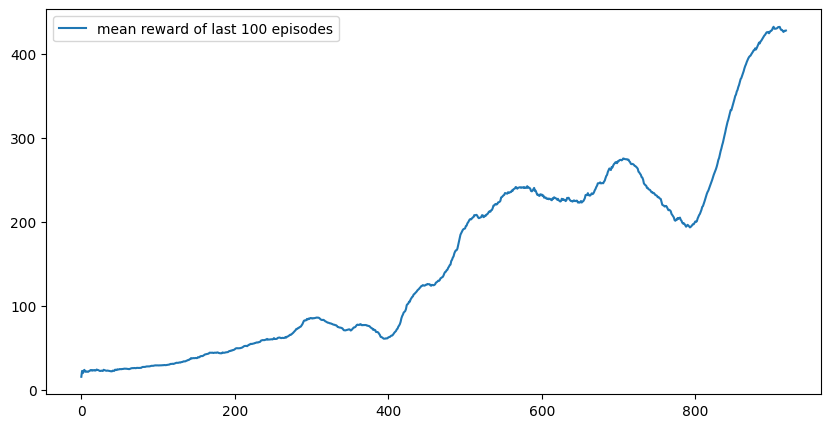

In [ ]:
#x=np.arange(0,episode-1)
y=results[:(episode-1),1]

plt.figure(figsize=(10, 5))
plt.plot(y, label='mean reward of last 100 episodes')
plt.legend()
plt.show()
plt.close()


# Vanilla Policy Gradient (VPG)
### State Value model

In [ ]:
class SVmodel(nn.Module):
    def __init__(self,
                 input_dim,
                 output_dim=1,
                 hidden_dims=(32,32),
                 activation_fc=F.relu):
        super(SVmodel, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    def _format(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
            x = x.unsqueeze(0)
        return x

    def forward(self, state):
        x = self._format(state)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        return self.output_layer(x)

### VPG Learning Functions

In [ ]:
def VPG_interaction_step(agent_PGmodel, agent_SVmodel, state, env,
                         logpas, entropies, rewards, values,
                         episode_reward, episode_timestep, episode_exploration):
        action, is_exploratory, logpa, entropy = agent_PGmodel.full_pass(state)
        new_state, reward, is_terminal, info = env.step(action)
        is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']

        logpas.append(logpa)
        entropies.append(entropy)
        rewards.append(reward)
        values.append(agent_SVmodel(state))

        episode_reward[-1] += reward
        episode_timestep[-1] += 1
        episode_exploration[-1] += int(is_exploratory)
        return new_state, is_terminal, is_truncated

def optimizing_VPG(agent_PGmodel, agent_SVmodel,
                   rewards, gamma, logpas, entropies, values,
                   entropy_loss_weight,
                   policy_optimizer, value_optimizer):
    T = len(rewards)
    discounts = np.logspace(0, T, num=T, base=gamma, endpoint=False)
    returns = np.array([np.sum(discounts[:T-t] * rewards[t:]) for t in range(T)])

    discounts = torch.FloatTensor(discounts[:-1]).unsqueeze(1)
    returns = torch.FloatTensor(returns[:-1]).unsqueeze(1)
    logpas = torch.cat(logpas)
    entropies = torch.cat(entropies)
    values = torch.cat(values)

    ################## fill below ##################
    logpas = []; entropies = []; rewards = []; values = []
    while not is_terminal:
      new_state, is_terminal, is_truncated = VPG_interaction_step(agent_PG, agent_SV,
                                                              state, env,
                                                              logpas, entropies, rewards, values,
                                                              episode_reward, episode_timestep, episode_exploration)
    state = new_state




    #policy_optimizer.zero_grad()
    #loss.backward()
    #torch.nn.utils.clip_grad_norm_(agent_PGmodel.parameters(), 1)
    #policy_optimizer.step()

    ################## fill below ##################



    #value_optimizer.zero_grad()
    #value_loss.backward()
    #torch.nn.utils.clip_grad_norm_(agent_SVmodel.parameters(), float('inf'))
    #value_optimizer.step()

### VPG Simulation

In [ ]:
# should change to VPG

environment_settings = {
    'env_name': 'CartPole-v1',
    'gamma': 1.00,
    'max_minutes': 10,
    'max_episodes': 10000,
    'goal_mean_100_reward': 475
}
env_name, gamma, max_minutes, \
max_episodes, goal_mean_100_reward = environment_settings.values()

seed = 12
policy_optimizer_lr = 0.0005
value_optimizer_lr = 0.0007
entropy_loss_weight = 0.001

env = gym.make('CartPole-v1')
nS, nA = env.observation_space.shape[0], env.action_space.n


training_start, last_debug_time = time.time(), float('-inf')
torch.manual_seed(seed) ; np.random.seed(seed) ; random.seed(seed)

episode_timestep = []
episode_reward = []
episode_seconds = []
episode_exploration = []
evaluation_scores = []

agent_PG = PGmodel(nS,nA, hidden_dims=(128,64)) # policy_model
policy_optimizer = optim.Adam(agent_PG.parameters(), lr=policy_optimizer_lr) # policy_optimizer
agent_SV = SVmodel(nS, hidden_dims=(256,128)) # value_model
value_optimizer = optim.RMSprop(agent_SV.parameters(), lr=value_optimizer_lr)

results = np.empty((max_episodes, 5))
# results = [total_step, mean_100_reward, mean_100_eval_score, training_time, wallclock_elapsed]
results[:] = np.nan
training_time = 0

for episode in range(1, max_episodes + 1):
    episode_start = time.time()

    state, is_terminal = env.reset(), False
    episode_reward.append(0.0)
    episode_timestep.append(0.0)
    episode_exploration.append(0.0)

    ################## fill below ##################
    # collect rollout







    # optimizing the model, once per episode







    ################# fill below ##################
    # collect statistics
    training_is_over, reached_debug_time = stats(agent_PG, env, training_time, last_debug_time, results,
                                                            episode_start, episode_seconds, episode_timestep,
                                                            episode_reward, episode_exploration)

    if reached_debug_time or training_is_over:
        last_debug_time = time.time()
    if training_is_over: break

el 00:00:00, ep 0000, ts 000012, ar 10 012.0±000.0, 100 012.0±000.0, ex 100 0.6±0.0, ev 024.0±000.0
el 00:00:30, ep 0162, ts 008182, ar 10 141.5±037.9, 100 063.3±051.0, ex 100 0.4±0.1, ev 183.6±134.2
el 00:01:00, ep 0240, ts 019724, ar 10 223.5±116.6, 100 144.5±081.1, ex 100 0.3±0.0, ev 377.4±105.0
el 00:01:31, ep 0298, ts 034095, ar 10 265.9±134.2, 100 214.8±108.8, ex 100 0.3±0.0, ev 385.2±090.5
el 00:02:01, ep 0339, ts 049320, ar 10 335.1±120.3, 100 298.8±127.8, ex 100 0.3±0.0, ev 436.2±088.8
el 00:02:31, ep 0378, ts 065069, ar 10 407.6±080.4, 100 360.4±124.3, ex 100 0.3±0.0, ev 476.4±059.1
--> reached_goal_mean_reward ✓


### VPG Results

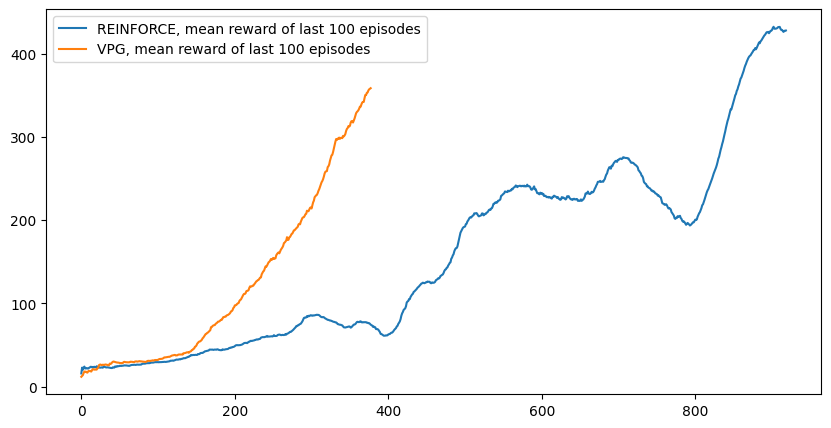

In [ ]:
#x=np.arange(0,episode-1)
z=results[:(episode-1),1]

plt.figure(figsize=(10, 5))
plt.plot(y, label='REINFORCE, mean reward of last 100 episodes')
plt.plot(z, label='VPG, mean reward of last 100 episodes')
plt.legend()
plt.show()
plt.close()
